#Installing & Importing Packages


In [ ]:
!pip install pyldavis
!pip install -U spacy

In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import json
import glob
import pandas as pd
import numpy as np

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
!python -m spacy download de_core_news_sm
spacy_de = spacy.load('de_core_news_sm')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

2023-09-02 10:42:37.961028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 35.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preparig the Data

In [ ]:
#LOAD DATA AND REMOVE UNNECESSARY TERMS
data = pd.read_csv ('/content/FDP_110.csv', index_col=0)
replacements = {'Sehr geehrter Herr Präsident!','Sehr geehrte Frau Präsidentin!', 'Meine lieben Kolleginnen und Kollegen!', 'Liebe Kolleginnen und Kollegen!', 'Frau Präsidentin!', 'Herr Präsident', 'Sehr geehrte Kolleginnen und Kollegen!', 'Sehr geehrte Damen und Herren!', 'Sehr geehrte Kolleginnen und Kollegen!', 'Verehrte Kolleginnen und Kollegen!', 'Verehrte Kolleginnen und Kollegen!', 'Meine sehr verehrten Damen und Herren!', 'Meine sehr geehrten Kolleginnen und Kollegen!', 'Meine Damen und Herren', 'Kolleginnen', 'Kollegen', 'Damen', 'Herren'}
data['content'] = data['content'].replace(replacements, '', regex=True)
data = data['content']

stopwords = stopwords.words('german')
data = data.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopwords]))

In [ ]:
#LEMMATIZATION
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("de_core_news_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(data)

In [ ]:
#WORD-GENERATION
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['gestern', 'insbesondere', 'neu', 'fraktion', 'heutig', 'tag', 'einstimmen', 'weihevoll', 'tag', 'sprechen', 'tag', 'bisschen', 'ahnlich', 'taufe', 'erstkommunion', 'ganz', 'neu', 'leben', 'erleben', 'auch']


In [ ]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['gestern', 'insbesondere', 'neu', 'fraktion', 'heutig', 'tag', 'einstimmen', 'weihevoll', 'tag', 'sprechen', 'tag', 'bisschen', 'ahnlich', 'taufe', 'erstkommunion', 'ganz', 'neu', 'leben', 'erleben', 'auch']


In [ ]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [ ]:
#LDA-MODEL
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

# Vizualizing the Data

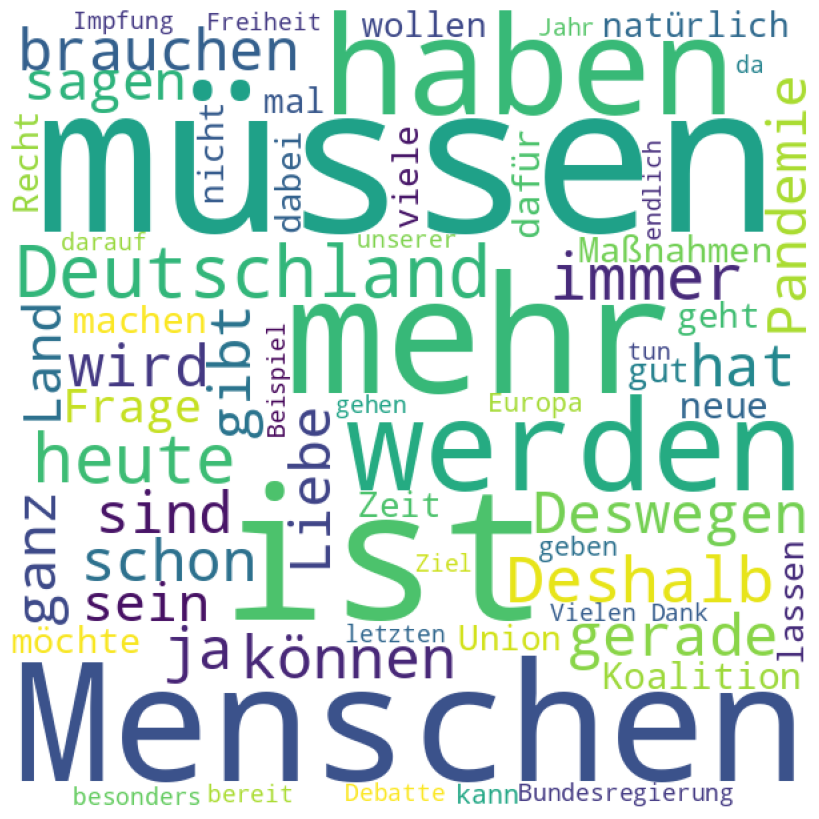

In [ ]:
text = ' '.join(data)

wordcloud = WordCloud(width=600, height=600,
                      background_color='white',
                      min_font_size=10).generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=20)
vis

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.332645 -0.178581       1        1  14.142148
7     -0.319339 -0.032696       2        1  12.669427
19    -0.099395 -0.381560       3        1  11.345721
17    -0.065050 -0.202676       4        1   8.224915
4      0.115824  0.296701       5        1   7.468905
16    -0.217210  0.324938       6        1   7.034376
13    -0.308329  0.138367       7        1   4.891445
1     -0.088423 -0.081675       8        1   4.194156
12     0.102657 -0.284993       9        1   4.180312
9      0.224769 -0.178684      10        1   3.650819
14     0.329671 -0.065518      11        1   3.174358
2      0.307098  0.182391      12        1   3.168439
3     -0.055867  0.027715      13        1   3.158621
10     0.150019  0.119782      14        1   2.985700
5      0.009753  0.088689      15        1   2.872388
15    -0.046505  0.285756      16        1   2.746403
18     0.085490 -0.063271      17        1   1.993568
8      0.112537  0.002518      18        1   1.728015
0      0.049998 -0.000128      19        1   0.216492
11     0.044946  0.002925      20        1   0.153794, topic_info=            Term        Freq       Total Category  logprob  loglift
92          jahr  134.000000  134.000000  Default  20.0000  20.0000
135        sagen  143.000000  143.000000  Default  19.0000  19.0000
1726   besonders   69.000000   69.000000  Default  18.0000  18.0000
66          ganz  130.000000  130.000000  Default  17.0000  17.0000
184         zeit   68.000000   68.000000  Default  16.0000  16.0000
...          ...         ...         ...      ...      ...      ...
3973  aufwertung    0.055740    1.280813  Topic20  -6.4044   3.3428
1064  beseitigen    0.055792    2.367679  Topic20  -6.4035   2.7293
730    ausgleich    0.055792    3.111880  Topic20  -6.4035   2.4560
3045       saule    0.055791    2.125709  Topic20  -6.4035   2.8371
3142   versorgen    0.055767    1.872707  Topic20  -6.4039   2.9633

[680 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2003      7  0.313269      abgabe
2003     18  0.626539      abgabe
3630     18  0.546155    abhangig
5213      6  0.941222   ablehnung
3147     15  0.710092   abschnitt
...     ...       ...         ...
1373     16  0.756562  zustimmung
191       1  0.332210     zweiter
191       5  0.073825     zweiter
191       6  0.516772     zweiter
191      15  0.036912     zweiter

[1144 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 20, 18, 5, 17, 14, 2, 13, 10, 15, 3, 4, 11, 6, 16, 19, 9, 1, 12])